In [93]:
import pandas as pd
import numpy as np
from ast import literal_eval
import gensim
import pickle
from wordcloud import WordCloud
from matplotlib import pyplot as plt

In [2]:
%%time
# читаем данные
df = pd.read_csv("df.csv")

Wall time: 6.94 s


In [3]:
# достаем BOW по иснструкции из задачи
bag_of_words = df.text_bow.apply(literal_eval)

In [4]:
%%time
# Build the bigram models
bigram = gensim.models.Phrases(bag_of_words, min_count=5, threshold=100) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

Wall time: 1min 27s


In [5]:
# добавляем биграммы в наш мешок
bag_of_words_with_bigram = list(bigram[bag_of_words])

In [6]:
# создаем объект словаря
id2word = gensim.corpora.Dictionary(bag_of_words_with_bigram)

In [7]:
# фильтруем в соответствии с рекомендациями из задания
id2word.filter_extremes(no_below=3, no_above=0.4, keep_n=3*10**6)

In [8]:
# вычисляем корпус слов
corpus = [id2word.doc2bow(text) for text in bag_of_words_with_bigram]

In [9]:
# согласно заданию корпус нужно сохранить
with open('corpus.pkl', 'wb') as f:
    pickle.dump(corpus, f)

In [10]:
%%time
# тренируем модель с учетом рекомендованных параметров
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    eval_every=20, num_topics=30, passes=5,
    random_state=42,
    )

Wall time: 9min 28s


In [17]:
#поработаем над визуализацией

In [45]:
def plotWordCloud(topic_number):
    """
        Строит визуализацию слов на основе текстов топиков
    """
    # получаем частоты и слова топика

    freq = \
    {el.split("*")[1].strip().replace('"', ""): float(el.split("*")[0]) 
     for el in lda_model.print_topics(-1)[topic_number][1].split("+")
    }
    
    # строим облако слов
    wordcloud = WordCloud(background_color="white", max_words=100, width=900, height=900, collocations=False)
    wordcloud = wordcloud.generate_from_frequencies(freq)
    plt.figure(figsize=(10, 7))
    plt.title("Топик номер {}".format(topic_number))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off");

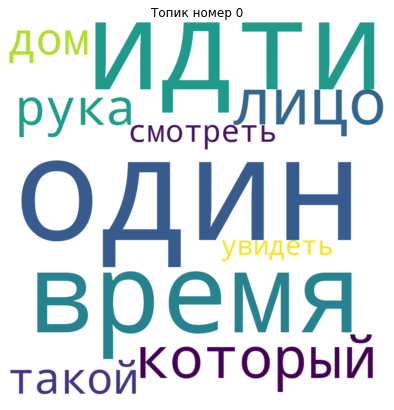

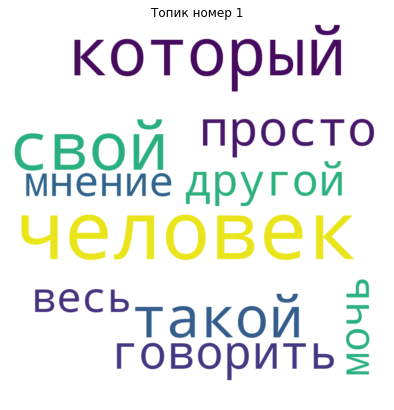

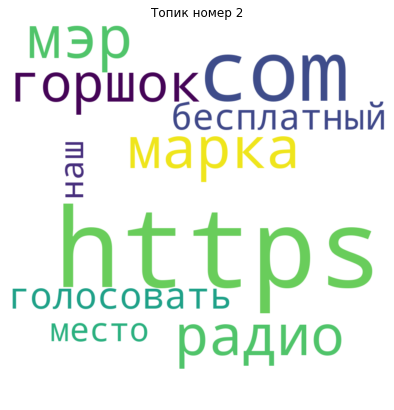

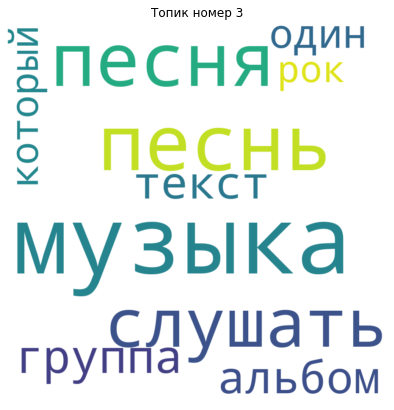

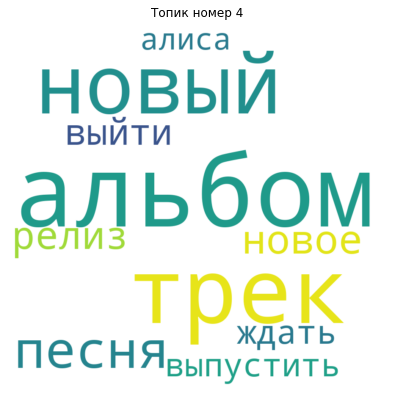

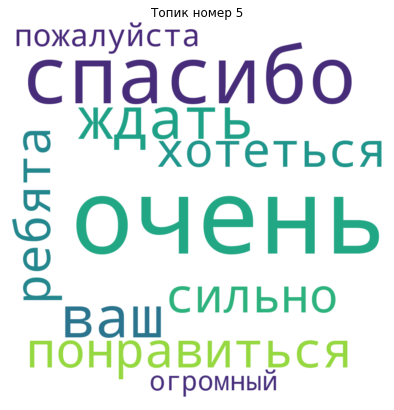

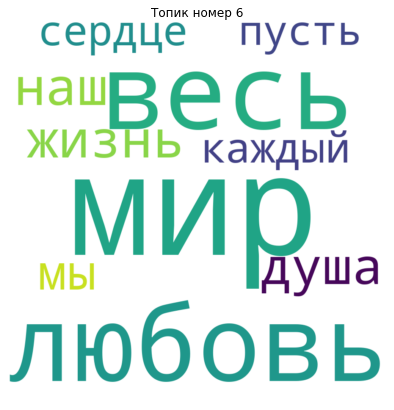

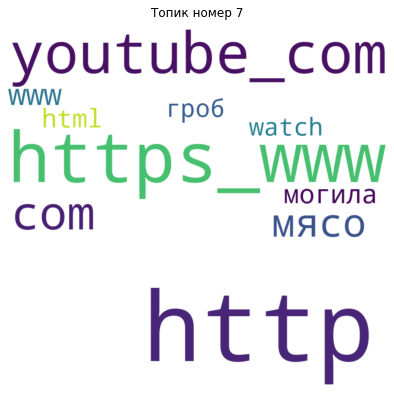

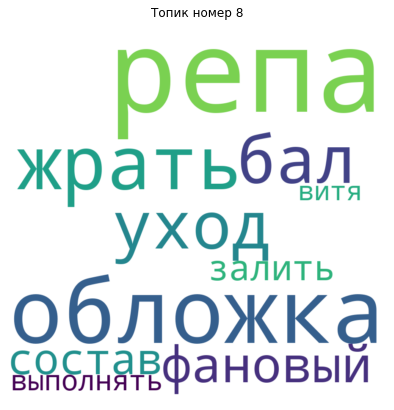

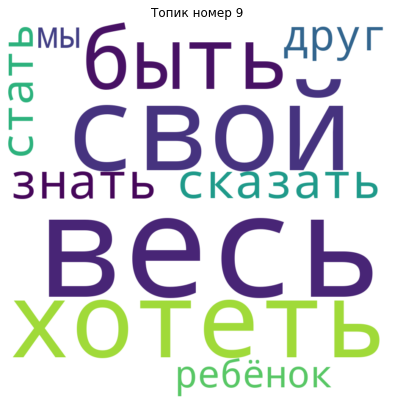

In [47]:
for n in range(0,10):
    plotWordCloud(n)

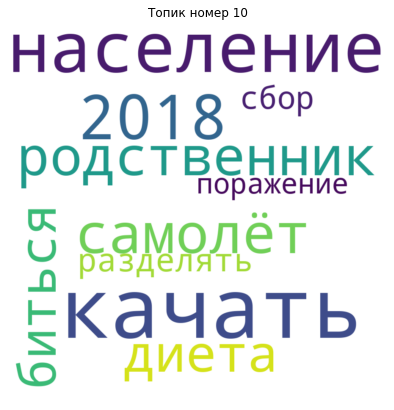

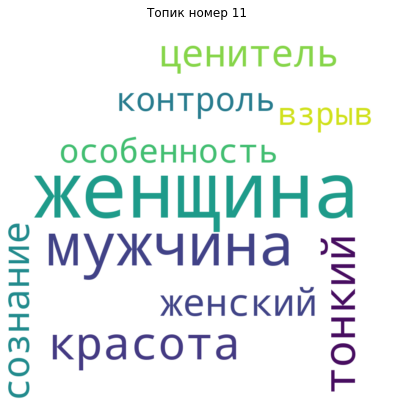

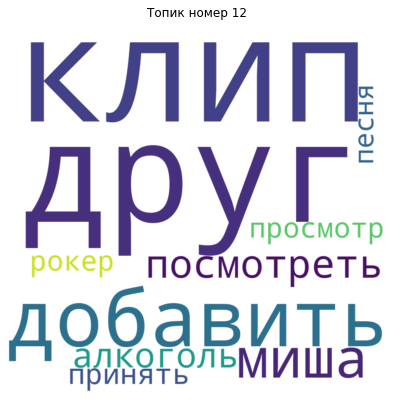

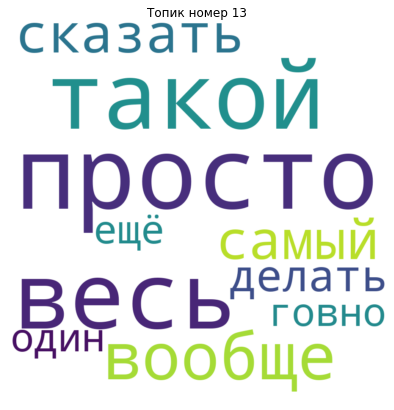

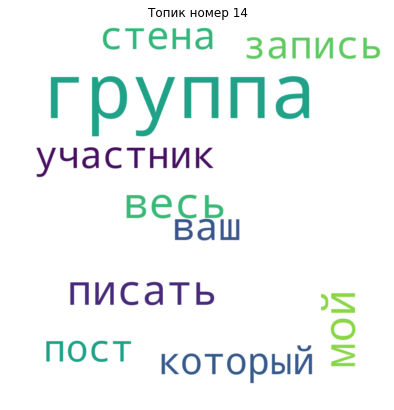

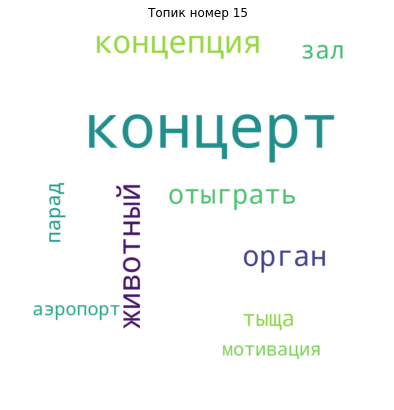

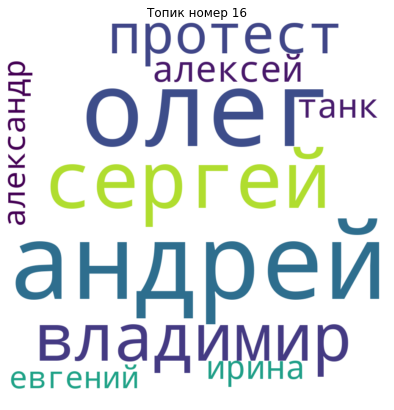

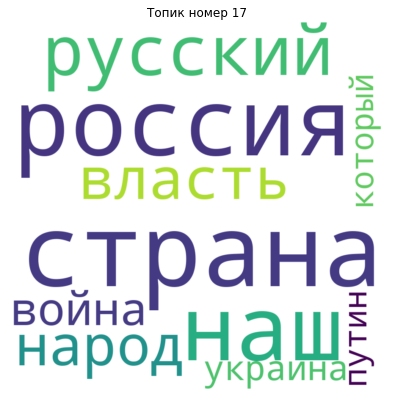

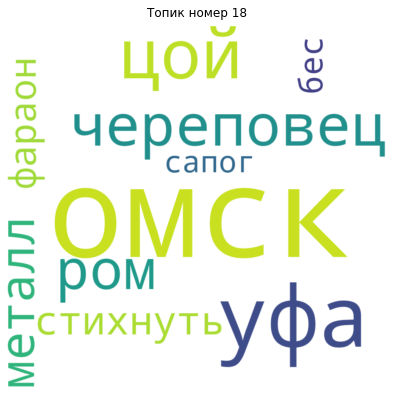

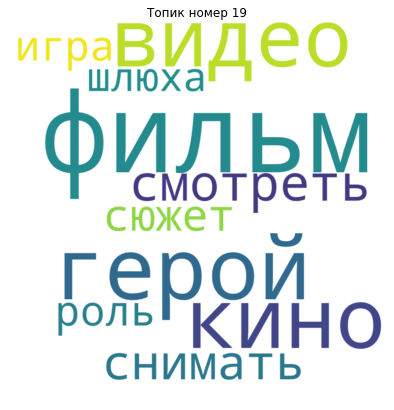

In [48]:
for n in range(10,20):
    plotWordCloud(n)

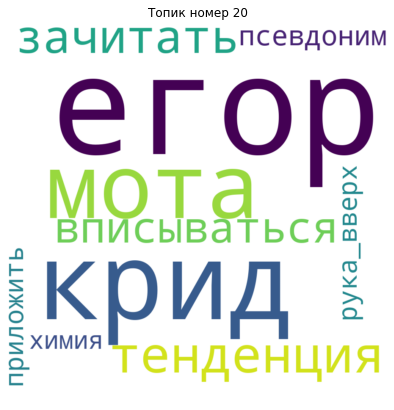

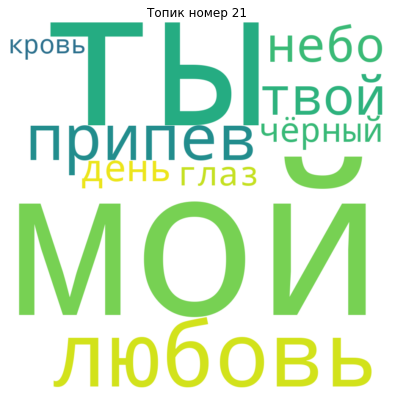

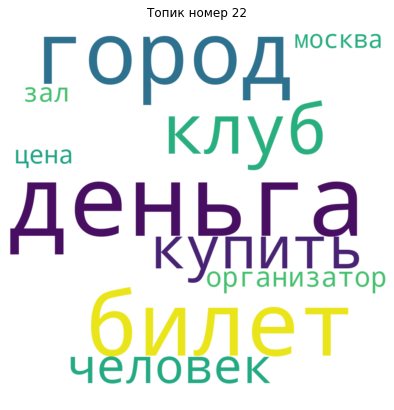

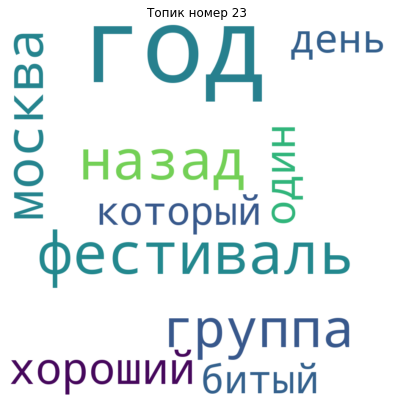

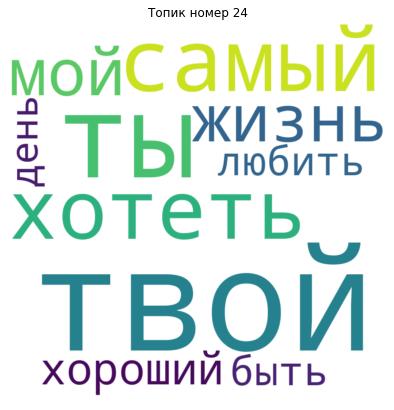

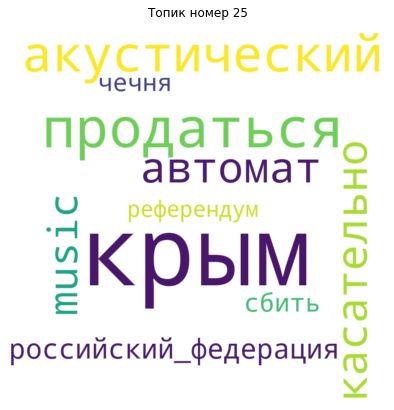

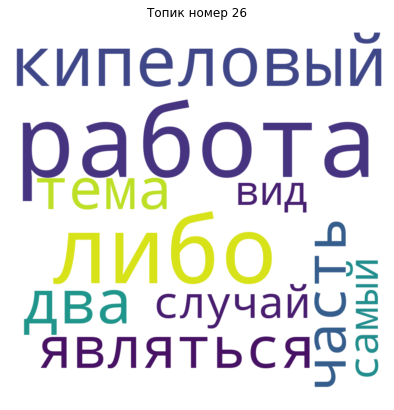

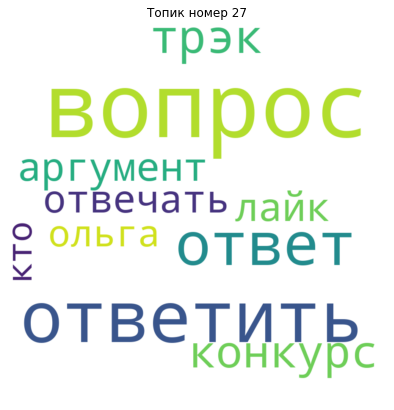

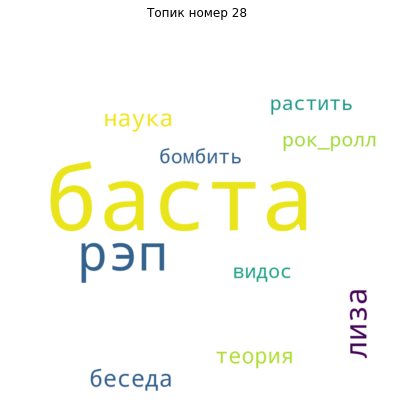

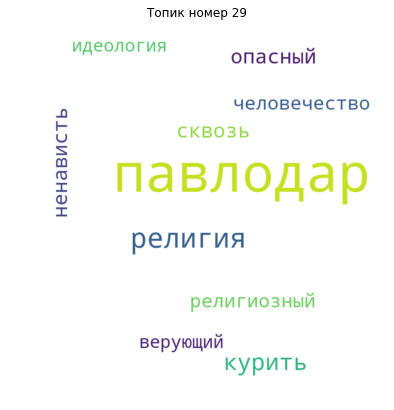

In [49]:
for n in range(20,30):
    plotWordCloud(n)

In [ ]:
# проведем оценку набора топиков по нескольким группам

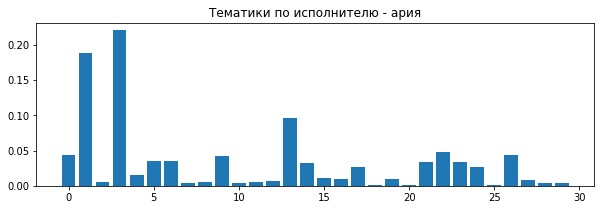

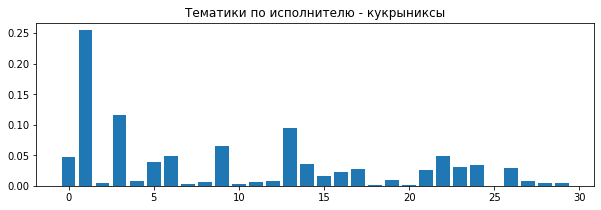

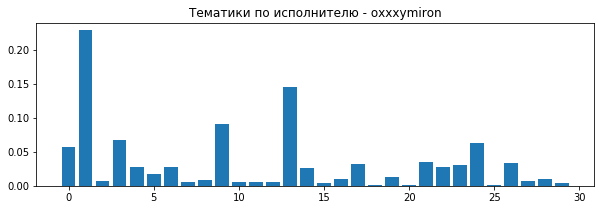

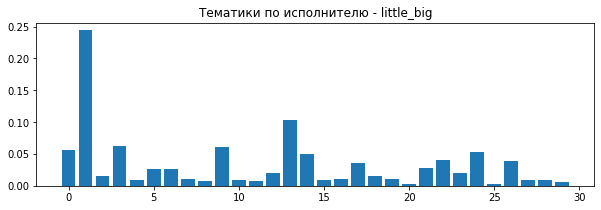

In [124]:
for performer in ['ария', "кукрыниксы", "oxxxymiron", "little_big"]:
    df_short = df[df.performer == performer]
    agg = np.zeros(lda_model.num_topics)
    for indx in df_short.index.to_numpy():
        d = dict(lda_model.get_document_topics(corpus[indx]))
        current = np.zeros(lda_model.num_topics)
        current[list(d.keys())] = list(d.values())
        agg = agg + current
    theme_profile = agg / np.sum(agg)
#     theme_profile = list(zip(range(30),theme_profile))
#     print(theme_profile)
    plt.figure(figsize=(10, 3))
    plt.title("Тематики по исполнителю - {}".format(performer))
    plt.bar(list(range(30)),theme_profile )

In [126]:
# подготовим набр векторов для TSNE
names = []
vectors = []
for performer in df.performer.unique():
    df_short = df[df.performer == performer]
    agg = np.zeros(lda_model.num_topics)
    for indx in df_short.index.to_numpy():
        d = dict(lda_model.get_document_topics(corpus[indx]))
        current = np.zeros(lda_model.num_topics)
        current[list(d.keys())] = list(d.values())
        agg = agg + current
    theme_profile = agg / np.sum(agg)
#     theme_profile = list(zip(range(30),theme_profile))
#     print(theme_profile)
    names.append(performer)
    vectors.append(theme_profile)

In [140]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=3)
tsne_transformed = tsne.fit_transform(pd.DataFrame(vectors))

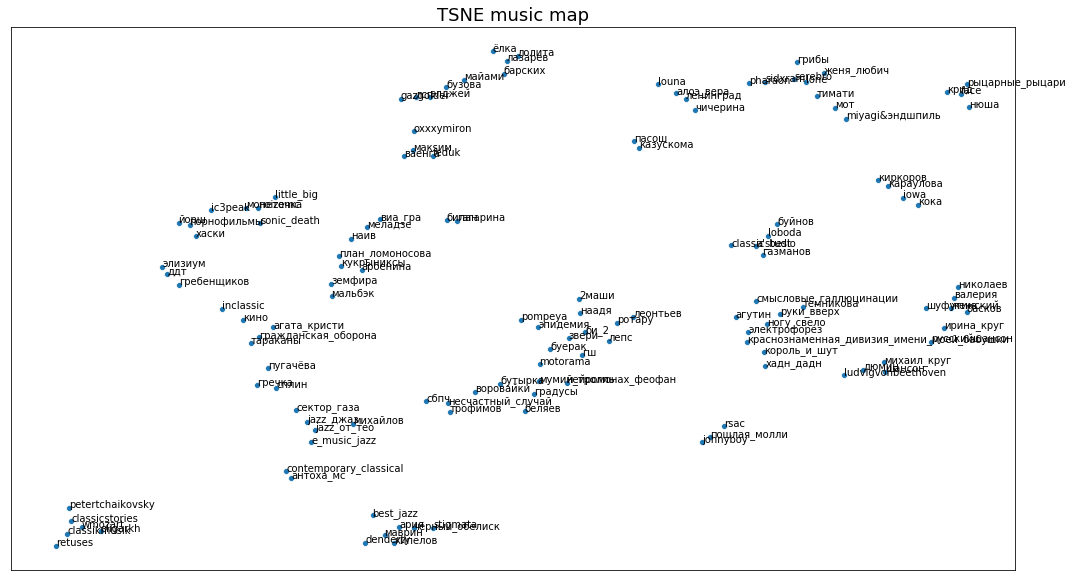

In [141]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(18, 10))
sns.scatterplot(
    x=tsne_transformed[:, 0], 
    y=tsne_transformed[:, 1], 
#     hue=y_sample.astype(int), 
    palette="CMRmap",
    legend='full'
)
plt.title("TSNE music map", fontsize=18)
plt.setp(ax, xticks=[], yticks=[])
for i, txt in enumerate(names):
    ax.annotate(txt, (tsne_transformed[i, 0], tsne_transformed[i, 1]))
plt.show()